In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from matplotlib import gridspec

import sys
sys.path.append("../")
from create_spec import create_spec
from fit2gauss import fit2gauss

In [3]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/f4.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/f4_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

/Users/WilliamHenryAshfieldIV/synth_spec/create_spec.py:98: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


a2g[0] = 11464523.275981983
a1g[0] = 52626028.670418195
chi2g =  1.4600043591913784e-05
a2g =  [1.14645233e+07 1.40321461e+03 1.02125228e-01 4.55557809e+07
 1.40332179e+03 1.02257383e-01]
chi1g =  91.52505926632591
chi2g =  1.4600043591913784e-05


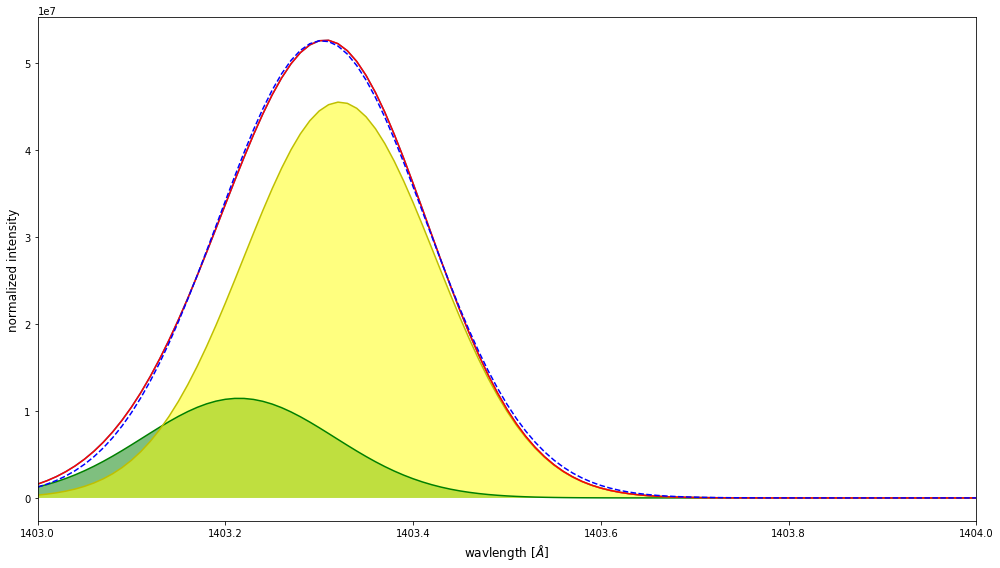

In [4]:
wav,spec,error = create_spec(tube,frac,log10T,log10G,time=197)
errorII = np.sqrt(spec) # actual error
np.nan_to_num(errorII, copy=False, nan=0)
# add small continuum to calculated spectrum error
rando = np.random.randn(2000)*0.1*np.max(spec) #
too_small = np.where(errorII < 0.01*np.max(spec))
errorII += rando

res = fit2gauss(wav,spec,errorII,verbose=True)

# extract arrays
y2a = res["y2a"]
y2b = res["y2b"]
y1g = res["y1g"]

#plot 
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])
# spectra
ax1.plot(wav, spec)
# peak 1
ax1.plot(wav, y2a, "g")
ax1.fill_between(wav, y2a.min(), y2a, facecolor="green", alpha=0.5)
# peak 2
ax1.plot(wav, y2b, "y")
ax1.fill_between(wav, y2b.min(), y2b, facecolor="yellow", alpha=0.5) 
#both
ax1.plot(wav,y2a+y2b, "r")
# single fit
ax1.plot(wav,y1g,'b--')

plt.xlim(1403,1404)
ax1.set_xlabel("wavlength [$\AA$]",  fontsize=12)
ax1.set_ylabel("normalized intensity",  fontsize=12)
fig.tight_layout()

In [5]:
a1g = res["a1g"]
a2g = res["a2g"]

line = 1403
l1 = a2g[1]
l2 = a2g[4]
v1 = (l1-line)/line*3e5
v2 = (l2-line)/line*3e5


print('red velocity = ',v1,'-----', '"blue" velocity = ', v2)

red velocity =  45.889483728610855 ----- "blue" velocity =  68.80677591238229


In [6]:
# single Gaussian
line = 1403
l1 = a1g[1]
v1 = (l1-line)/line*3e5
print('red velocity = ',v1)

red velocity =  64.77019319711704


In [8]:
N = len(tube.tarr) # length of tarr in time steps 
print(N)

501


In [9]:
v_r = np.zeros(N)
v_b = np.zeros(N)
for i in range(N):
    while True:
            try:
                wav,spec,error = create_spec(tube,frac,log10T,log10G,time=i)

                errorII = np.sqrt(spec) # actual error
                np.nan_to_num(errorII, copy=False, nan=0)
                # add small continuum to calculated spectrum error
                rando = np.random.randn(2000)*0.1*np.max(spec) #
                too_small = np.where(errorII < 0.01*np.max(spec))
                errorII += rando

                res = fit2gauss(wav,spec,errorII)
                a2g = res["a2g"] # extract fit parameters

                #calculate Doppler velocities
                line = 1403
                v1 = (a2g[1]-line)/line*3e5 # in km/s
                v2 = (a2g[4]-line)/line*3e5
                
                v_r[i] = np.maximum(v1,v2)
                v_b[i] = np.minimum(v1,v2)
                break

            except RuntimeError:
                print("shit!")
                print('i = ')
                continue
    
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/Users/WilliamHenryAshfieldIV/synth_spec/create_spec.py:98: RuntimeWarning: divide by zero encountered in true_divide
  factor = nei/eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_spec.py:144: RuntimeWarning: overflow encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
/Users/WilliamHenryAshfieldIV/synth_spec/create_spec.py:144: RuntimeWarning: invalid value encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
/Users/WilliamHenryAshfieldIV/synth_spec/fit2gauss.py:81: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(m2)
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could no

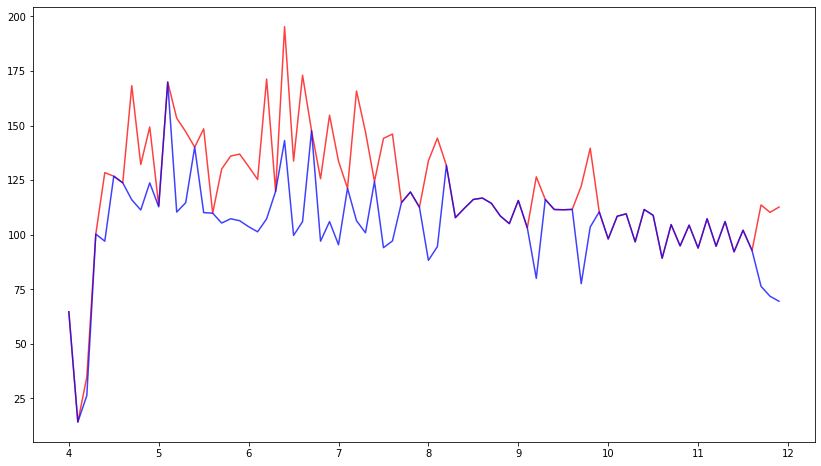

In [10]:
time = np.arange(0,50.1,0.1)
plt.figure(figsize=(14,8))
plt.plot(time[40:120],v_r[40:120],'r',alpha=0.75)
plt.plot(time[40:120],v_b[40:120],'b',alpha=0.75)

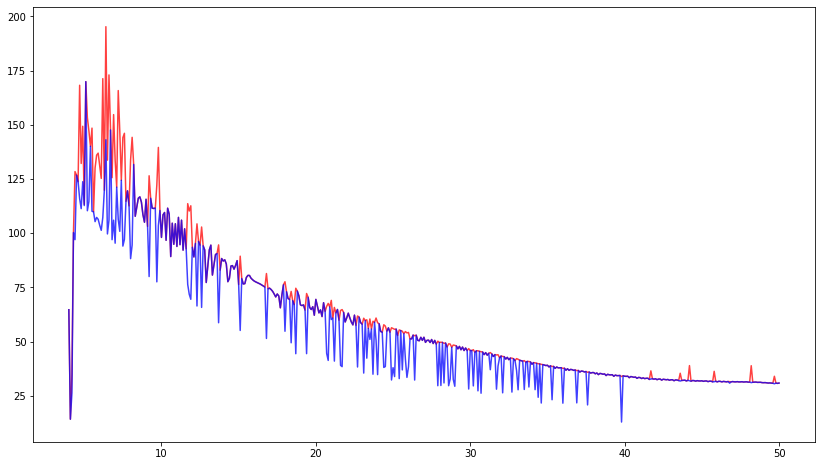

In [11]:
plt.figure(figsize=(14,8))
plt.plot(time[40:],v_r[40:],'r',alpha=0.75)
plt.plot(time[40:],v_b[40:],'b',alpha=0.75)